# 1. Импортирование библиотек и парсинг данных

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
import torch
import os
from glob import glob
from matplotlib.patches import Rectangle
from tqdm import tqdm
import shutil
import codecs
# Отключаем проверку
import warnings
warnings.filterwarnings("ignore")

In [2]:
list_bmp = [] # Массив путей к bmp
def parsing_bmp(dir):
    list = os.listdir(dir) # Список всех файлов в данной директории
    for item in glob(dir+'\\'+'*.bmp'):
        list_bmp.append(item) # Добавляем в массив названий файлов типа .bmp
    for dir_for in list:
        if os.path.isdir(dir+'\\'+dir_for): # Если это директория, то запускай функцию. Рекурсия :)
            parsing_bmp(dir+'\\'+dir_for)
parsing_bmp('.')
list_bmp[:10] # Выведем 

['.\\data\\test\\0.bmp',
 '.\\data\\test\\03.bmp',
 '.\\data\\test\\04.bmp',
 '.\\data\\test\\05.bmp',
 '.\\data\\test\\0_075.bmp',
 '.\\data\\test\\0_077.bmp',
 '.\\data\\test\\0_078.bmp',
 '.\\data\\test\\0_080.bmp',
 '.\\data\\test\\0_081.bmp',
 '.\\data\\test\\0_083.bmp']

In [3]:
print(f'Файлов формата bmp {len(list_bmp)}') 

Файлов формата bmp 14339


# 2. Чтение изображения

In [4]:
images = [] # Массив изображений
for file in tqdm(list_bmp):
    try:
        image = cv2.imread(file, cv2.IMREAD_COLOR) # Читаем изображение
        image = cv2.resize(image, dsize=(960, 600)) # Изменяем размер фото на 960x600
        images.append(image)
    except:
        pass
print(f'Прочиталось {len(images)} изображений')

100%|███████████████████████████████████████████████████████████████████████████| 14339/14339 [01:41<00:00, 141.75it/s]

Прочиталось 13652 изображений


Визуализируем пример с дефектом

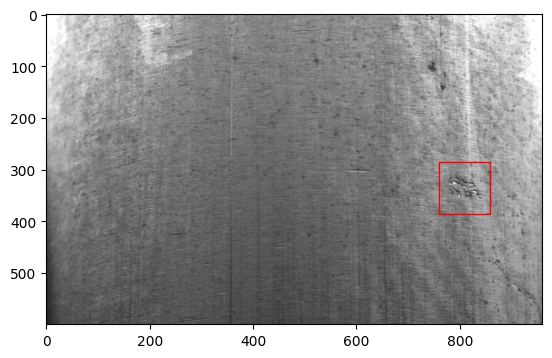

In [6]:
image = cv2.imread('.\\DATASET\\FRAMES\\0\\1538\\frame0006.bmp', cv2.IMREAD_COLOR) # Читаем изображение
image = np.array(image) # Переводим в numpy массивы
image = image.astype('float32') # Изменяем на тип float
image = image / 255.0 # Нормализируем пиксили
plt.gca().add_patch (Rectangle((809-50,336-50),100,100,edgecolor='red', facecolor='none', lw= 1 )) 
plt.imshow(image)

# 3. Чтение выборок 

In [7]:
root = 'data' # Папка с данными
def dict_frames_maker(path, prefix, sampling, *, show=False):
    '''
    Функция позволяет создать директорию с выборкой и разметкой для детекции
    Input:
        path - путь до файла формата .cfg
        prefix - путь до директории с фотографиями с камер
        sampling - имя выборки
        show - отобразить результат
    '''
    file = open(path, "r") # Открываем файл .cfg
    with codecs.open(path, 'r', encoding='cp1251') as fdata:
        list_lines = fdata.readlines() # Читаем построчно
    # Создаём папки с выборкой
    if not os.path.exists(root):
        os.mkdir(root)
    if not os.path.exists('.\\'+root+'\\'+sampling):
        os.mkdir('.\\'+root+'\\'+sampling)
    if not os.path.exists('.\\'+root+'\\' + sampling + '\\image\\'):
        os.mkdir('.\\'+root+'\\' + sampling + '\\image\\')
    if not os.path.exists('.\\'+root+'\\' + sampling + '\\label\\'):
        os.mkdir('.\\'+root+'\\' + sampling + '\\label\\')
    key = 0 #
    dict_frames = {} # Словарь с данными
    dict_value = [] # Список с данными по фото

    # Проходимся по файлу .cfg
    for item in list_lines:
        item = item[:-2] # Убираем последние пустые символы
        if item.endswith('.frame'):
            # Если в файле нет записей, то записываем заглушку 
            if len(dict_value) == 0:
                dict_frames[key] = '0 0.0 0.0 0.0 0.0'
            else:
                dict_frames[key] = dict_value
            key = prefix+item # Путь до файла
            key = key.replace(".frame", ".bmp") # Переименуем путь до файла с формата .frame до .bmp
            dict_value = [] # Очищаем список по фото
        else:
            # Если фотография не будет битой, то занесём в список
            try:
                height, width, channels = cv2.imread(key).shape # Получаем размеры изображения
                items_coor = [int(i) for i in item.split(', ')] # массив детекции с X, Y, CLASS
                # Добавляем строку формата CLASS X Y WIDTH HEIGHT
                dict_value.append(' '.join([str(items_coor[2]), str(round((items_coor[0]) / width, 6)), 
                                            str(round((items_coor[1]) / height, 6)), str(round((items_coor[0] + 25) / width, 6)), 
                                            str(round((items_coor[1] + 25) / height, 6))]))
            except:
                pass
    del dict_frames[0]
    # Проходимся по всем файлам
    for item in dict_frames.keys():
        try:
            # Копируем изображение в новое место
            shutil.copy(item, '.\\'+root+'\\'+sampling+'\\'+item[item.rfind('\\'):])
            # Открываем txt с таким же названием и записываем данные о дефекте 
            with open('.\\'+root+'\\'+sampling+'\\'+item[item.rfind('\\'):].replace('.bmp', '.txt'), 'w') as f:
                for i in dict_frames[item]:
                    f.write(i+'\n') 
        except:
            pass
    # Выводим в консоль весб
    if show:
        for key in dict_frames: 
            print(key + ':', dict_frames[key])
    return dict_frames

Тренировочная выборка

In [8]:
%%time
path = ".\\DATASET\\metadata\\set.cfg"
prefix = '.\\DATASET\\FRAMES\\'
train_json = dict_frames_maker(path, prefix, 'train')
train_json

CPU times: total: 15.9 s
Wall time: 2min 4s


{'.\\DATASET\\FRAMES\\0\\1538\\frame0006.bmp': ['3 0.842708 0.56 0.86875 0.601667',
  '0 0.626042 0.498333 0.652083 0.54'],
 '.\\DATASET\\FRAMES\\0\\1538\\frame0007.bmp': ['3 0.694792 0.53 0.720833 0.571667',
  '3 0.844792 0.871667 0.870833 0.913333',
  '0 0.463542 0.5 0.489583 0.541667',
  '0 0.352083 0.156667 0.378125 0.198333',
  '0 0.898958 0.451667 0.925 0.493333'],
 '.\\DATASET\\FRAMES\\0\\1538\\frame0009.bmp': ['3 0.6 0.521667 0.626042 0.563333',
  '3 0.754167 0.848333 0.780208 0.89',
  '0 0.9 0.65 0.926042 0.691667'],
 '.\\DATASET\\FRAMES\\0\\1538\\frame0011.bmp': ['3 0.497917 0.84 0.523958 0.881667',
  '3 0.339583 0.536667 0.365625 0.578333',
  '0 0.654167 0.161667 0.680208 0.203333'],
 '.\\DATASET\\FRAMES\\0\\1538\\frame0012.bmp': ['3 0.290625 0.543333 0.316667 0.585',
  '3 0.45 0.838333 0.476042 0.88',
  '0 0.280208 0.158333 0.30625 0.2'],
 '.\\DATASET\\FRAMES\\0\\1538\\frame0013.bmp': ['3 0.252083 0.551667 0.278125 0.593333',
  '3 0.391667 0.851667 0.417708 0.893333',
  '0 

Тестовая выборка

In [9]:
%%time
path = ".\\DATASET\\metadata\\test_set.cfg"
prefix = '.\\DATASET\\FRAMES\\'
test_json = dict_frames_maker(path, prefix, 'test')
test_json

CPU times: total: 6.39 s
Wall time: 17 s


{'.\\DATASET\\FRAMES\\0\\1538\\frame0006.bmp': ['3 0.842708 0.56 0.86875 0.601667'],
 '.\\DATASET\\FRAMES\\0\\1538\\frame0007.bmp': ['3 0.694792 0.53 0.720833 0.571667',
  '3 0.844792 0.871667 0.870833 0.913333'],
 '.\\DATASET\\FRAMES\\0\\1538\\frame0009.bmp': ['3 0.6 0.521667 0.626042 0.563333',
  '3 0.754167 0.848333 0.780208 0.89'],
 '.\\DATASET\\FRAMES\\0\\1538\\frame0011.bmp': ['3 0.497917 0.84 0.523958 0.881667',
  '3 0.339583 0.536667 0.365625 0.578333'],
 '.\\DATASET\\FRAMES\\0\\1538\\frame0012.bmp': ['3 0.290625 0.543333 0.316667 0.585',
  '3 0.45 0.838333 0.476042 0.88'],
 '.\\DATASET\\FRAMES\\0\\1538\\frame0013.bmp': ['3 0.252083 0.551667 0.278125 0.593333',
  '3 0.391667 0.851667 0.417708 0.893333',
  '0 0.225 0.255 0.251042 0.296667',
  '0 0.897917 0.36 0.923958 0.401667',
  '0 0.604167 0.601667 0.630208 0.643333'],
 '.\\DATASET\\FRAMES\\0\\1538\\frame0015.bmp': ['3 0.127083 0.593333 0.153125 0.635',
  '3 0.245833 0.856667 0.271875 0.898333'],
 '.\\DATASET\\FRAMES\\0\\1538

In [12]:
count_train = len(os.listdir('.\\'+root+'\\train\\')) # Количество фото в тренировочной выборке
count_test = len(os.listdir('.\\'+root+'\\test\\')) # Количество фото в тестовой выборке
print(f"Изображений в тренировочной выборке: {count_train}\nИзображений в тестовой выборке {count_test}")
del count_test, count_train

Изображений в тренировочной выборке: 7566
Изображений в тестовой выборке 5500


In [13]:
# Формируем словарь
json_yalm = {
    "names": "DATASET",
    "train": "C:\\Users\\k1rsn\\Notebook\\Defect-Detection\\data\\train",
    "val": "C:\\Users\\k1rsn\\Notebook\\Defect-Detection\\data\\test",
}

def dict_classes_maker(path):
    '''
    Функция позволяет спарсить классы дефектов 
    Input:
        path - путь до конфига 
    '''
    # Читаем файл
    with codecs.open(path, 'r', encoding='cp1251') as fdata:
        list_lines = fdata.readlines() # Читаем по строкам файлы 
        my_dict = {} # Словарь классов 
        # Запустем цикл по всем строкам файла .cfg
        for line in list_lines:
            items = line.split(', ')
            my_dict[items[0].split()[1]] = items[-1][:-2]
        return my_dict

ded = dict_classes_maker('./DATASET/metadata/classes.cfg')

# Запишем в словарь
json_yalm['nc'] = len(list(ded.values()))
json_yalm['names'] = list(ded.values())
json_yalm

{'names': ['не дефект',
  'потертость',
  'черная точка',
  'плена',
  'маркер',
  'грязь',
  'накол',
  'н.д. накол',
  'микровыступ',
  'н.д. микровыступ',
  'вмятина',
  'мех.повреждение',
  'риска',
  'царапина с волчком'],
 'train': 'C:\\Users\\k1rsn\\Notebook\\Defect-Detection\\data\\train',
 'val': 'C:\\Users\\k1rsn\\Notebook\\Defect-Detection\\data\\test',
 'nc': 14}

In [14]:
import yaml

# Преобразование данных в формат YAML
yaml_data = yaml.dump(json_yalm)

# Запись данных в файл в формате YAML
with open('yaml_format.yaml', 'w', encoding='utf-8') as file:
    file.write(yaml_data)

# 4. Обучение нейросети

In [2]:
from ultralytics import YOLO
model = YOLO('yolov8n.yaml').load('yolov8n.pt')  #  загружаем стандартные веса


                   from  n    params  module                                       arguments                     
  0                  -1  1       928  ultralytics.nn.modules.conv.Conv             [3, 32, 3, 2]                 
  1                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  2                  -1  1     29056  ultralytics.nn.modules.block.C2f             [64, 64, 1, True]             
  3                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  4                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  5                  -1  1    295424  ultralytics.nn.modules.conv.Conv             [128, 256, 3, 2]              
  6                  -1  2    788480  ultralytics.nn.modules.block.C2f             [256, 256, 2, True]           
  7                  -1  1   1180672  ultralytics.nn.modules.conv.Conv             [256

In [3]:
results = model.train(data='yaml_format.yaml', epochs=100) # Запускае обучение на 100 эпох

Ultralytics YOLOv8.0.227 🚀 Python-3.11.5 torch-2.1.1+cu118 CUDA:0 (NVIDIA GeForce RTX 3050 Laptop GPU, 4096MiB)
engine\trainer: task=detect, mode=train, model=yolov8s.yaml, data=yaml_format.yaml, epochs=100, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train65, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_boxes=True, line_width=

train: Scanning C:\Users\k1rsn\Notebook\Defect-Detection\data\train.cache... 3782 images, 0 backgrounds, 271 corrupt: 1

train: WARNING ⚠️ C:\Users\k1rsn\Notebook\Defect-Detection\data\train\0_086_1.bmp: ignoring corrupt image/label: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (17,) + inhomogeneous part.
train: WARNING ⚠️ C:\Users\k1rsn\Notebook\Defect-Detection\data\train\0_087.bmp: ignoring corrupt image/label: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (17,) + inhomogeneous part.
train: WARNING ⚠️ C:\Users\k1rsn\Notebook\Defect-Detection\data\train\0_087_1.bmp: ignoring corrupt image/label: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (17,) + inhomogeneous part.
train: WARNING ⚠️ C:\Users\k1rsn\Notebook\Defect-Detection\data\train\0_095.bmp: ignoring corrupt image/label: setting an array element with a sequence. The requested array has an inh

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


val: Scanning C:\Users\k1rsn\Notebook\Defect-Detection\data\test.cache... 2749 images, 0 backgrounds, 205 corrupt: 100%

val: WARNING ⚠️ C:\Users\k1rsn\Notebook\Defect-Detection\data\test\0_086.bmp: ignoring corrupt image/label: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (17,) + inhomogeneous part.
val: WARNING ⚠️ C:\Users\k1rsn\Notebook\Defect-Detection\data\test\0_086_1.bmp: ignoring corrupt image/label: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (17,) + inhomogeneous part.
val: WARNING ⚠️ C:\Users\k1rsn\Notebook\Defect-Detection\data\test\0_087.bmp: ignoring corrupt image/label: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (17,) + inhomogeneous part.
val: WARNING ⚠️ C:\Users\k1rsn\Notebook\Defect-Detection\data\test\0_087_1.bmp: ignoring corrupt image/label: setting an array element with a sequence. The requested array has an inhomogeneous s

Plotting labels to runs\detect\train65\labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000556, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train65
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/100      4.25G      2.054      3.029      2.277         87        640: 100%|██████████| 220/220 [02:52<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 80/80 [00:49


                   all       2544       4517      0.373      0.257       0.09     0.0411

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/100      4.33G      1.545      2.371       1.92         71        640: 100%|██████████| 220/220 [03:39<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 80/80 [00:40


                   all       2544       4517      0.305      0.342      0.166     0.0844

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/100      4.34G      1.452      2.297      1.863         91        640: 100%|██████████| 220/220 [03:21<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 80/80 [00:50


                   all       2544       4517      0.316       0.25      0.116     0.0564

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/100      4.32G      1.387      2.252      1.823         73        640: 100%|██████████| 220/220 [04:30<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 80/80 [01:52


                   all       2544       4517      0.269      0.397      0.227      0.132

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/100      4.32G      1.338      2.198      1.775         84        640: 100%|██████████| 220/220 [03:28<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 80/80 [00:47


                   all       2544       4517      0.267      0.461      0.252      0.149

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/100      4.33G      1.308       2.17      1.754        104        640: 100%|██████████| 220/220 [04:28<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 80/80 [00:51


                   all       2544       4517      0.296      0.421      0.249      0.162

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/100      4.32G      1.269      2.155      1.727         71        640: 100%|██████████| 220/220 [03:15<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 80/80 [00:50


                   all       2544       4517      0.257      0.465      0.268      0.153

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/100      4.33G      1.247       2.14      1.715         74        640: 100%|██████████| 220/220 [06:30<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 80/80 [01:52


                   all       2544       4517      0.458      0.398      0.297      0.186

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/100      4.32G      1.223       2.11      1.688         82        640: 100%|██████████| 220/220 [02:50<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 80/80 [00:54


                   all       2544       4517      0.333       0.52      0.352      0.239

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/100      4.33G      1.203      2.099      1.675         53        640: 100%|██████████| 220/220 [04:32<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 80/80 [01:42


                   all       2544       4517      0.385      0.555      0.405      0.289

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/100      4.32G      1.174      2.063      1.651         98        640: 100%|██████████| 220/220 [03:51<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 80/80 [00:59


                   all       2544       4517      0.312      0.567      0.365      0.248

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/100      4.49G      1.179      2.073      1.666        106        640: 100%|██████████| 220/220 [05:00<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 80/80 [00:43


                   all       2544       4517      0.428      0.478      0.371      0.251

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/100      4.33G      1.148      2.048       1.64         75        640: 100%|██████████| 220/220 [03:49<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 80/80 [00:59


                   all       2544       4517      0.383      0.555      0.419      0.288

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/100      4.33G      1.138      2.029      1.637         78        640: 100%|██████████| 220/220 [05:09<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 80/80 [01:47


                   all       2544       4517      0.346      0.564       0.38      0.262

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/100      4.33G      1.116      2.019      1.616         73        640: 100%|██████████| 220/220 [04:54<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 80/80 [01:46


                   all       2544       4517      0.431      0.625       0.46      0.348

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/100      4.32G      1.104      2.003      1.603         81        640: 100%|██████████| 220/220 [04:37<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 80/80 [01:36

                   all       2544       4517      0.483      0.533      0.457      0.356



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/100      4.33G      1.101      2.015        1.6         92        640: 100%|██████████| 220/220 [02:42<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 80/80 [01:40

                   all       2544       4517      0.446      0.623      0.499      0.397



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/100      4.32G      1.097      1.987      1.597         65        640: 100%|██████████| 220/220 [04:44<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 80/80 [00:53

                   all       2544       4517      0.441       0.56      0.491      0.351



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/100      4.32G      1.077      1.988      1.583         85        640: 100%|██████████| 220/220 [03:56<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 80/80 [02:12


                   all       2544       4517      0.431      0.549      0.452      0.324

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/100      4.32G      1.062      1.983      1.578        109        640: 100%|██████████| 220/220 [04:01<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 80/80 [02:35


                   all       2544       4517      0.449      0.637      0.527      0.416

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/100      4.32G      1.055      1.971      1.571         65        640: 100%|██████████| 220/220 [06:51<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 80/80 [01:14


                   all       2544       4517      0.436      0.598      0.501      0.384

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/100      4.31G      1.043      1.956      1.567        109        640: 100%|██████████| 220/220 [06:25<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 80/80 [00:47


                   all       2544       4517      0.459      0.625      0.503      0.393

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/100      4.31G      1.045      1.937      1.561         97        640: 100%|██████████| 220/220 [06:25<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 80/80 [00:59

                   all       2544       4517      0.496      0.644      0.545      0.437



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/100      4.31G      1.063      1.907      1.578        199        640:   2%|▏         | 5/220 [00:08<06:18,  1.


KeyboardInterrupt: 

Дообучение весов

In [1]:
model = YOLO('.\\runs\\detect\\train60\\weights\\best.pt') # Путь до лучших весов прошлого обучения
results = model.train(data='yaml_format.yaml', epochs=100) # Запускаем обучение на 100 эпох

Ultralytics YOLOv8.0.227 🚀 Python-3.11.5 torch-2.1.1+cu118 CUDA:0 (NVIDIA GeForce RTX 3050 Laptop GPU, 4096MiB)
engine\trainer: task=detect, mode=train, model=.\runs\detect\train60\weights\best.pt, data=yaml_format.yaml, epochs=100, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train64, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, sho

train: Scanning C:\Users\k1rsn\Notebook\Defect-Detection\data\train.cache... 3782 images, 0 backgrounds, 271 corrupt: 1

train: WARNING ⚠️ C:\Users\k1rsn\Notebook\Defect-Detection\data\train\0_086_1.bmp: ignoring corrupt image/label: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (17,) + inhomogeneous part.
train: WARNING ⚠️ C:\Users\k1rsn\Notebook\Defect-Detection\data\train\0_087.bmp: ignoring corrupt image/label: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (17,) + inhomogeneous part.
train: WARNING ⚠️ C:\Users\k1rsn\Notebook\Defect-Detection\data\train\0_087_1.bmp: ignoring corrupt image/label: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (17,) + inhomogeneous part.
train: WARNING ⚠️ C:\Users\k1rsn\Notebook\Defect-Detection\data\train\0_095.bmp: ignoring corrupt image/label: setting an array element with a sequence. The requested array has an inh

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


val: Scanning C:\Users\k1rsn\Notebook\Defect-Detection\data\test.cache... 2749 images, 0 backgrounds, 205 corrupt: 100%

val: WARNING ⚠️ C:\Users\k1rsn\Notebook\Defect-Detection\data\test\0_086.bmp: ignoring corrupt image/label: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (17,) + inhomogeneous part.
val: WARNING ⚠️ C:\Users\k1rsn\Notebook\Defect-Detection\data\test\0_086_1.bmp: ignoring corrupt image/label: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (17,) + inhomogeneous part.
val: WARNING ⚠️ C:\Users\k1rsn\Notebook\Defect-Detection\data\test\0_087.bmp: ignoring corrupt image/label: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (17,) + inhomogeneous part.
val: WARNING ⚠️ C:\Users\k1rsn\Notebook\Defect-Detection\data\test\0_087_1.bmp: ignoring corrupt image/label: setting an array element with a sequence. The requested array has an inhomogeneous s

Plotting labels to runs\detect\train64\labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000556, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train64
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/100      2.49G      0.845      1.844      1.405         87        640: 100%|██████████| 220/220 [00:53<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 80/80 [00:21

                   all       2544       4517      0.558      0.743      0.631      0.545



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/100      2.51G      0.893      1.869      1.441         71        640: 100%|██████████| 220/220 [00:52<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 80/80 [00:20


                   all       2544       4517      0.518      0.685      0.572       0.45

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/100      2.51G     0.9223      1.906      1.464         91        640: 100%|██████████| 220/220 [00:53<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 80/80 [00:23


                   all       2544       4517      0.469      0.661      0.549      0.447

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/100      2.51G     0.9626       1.92      1.493         73        640: 100%|██████████| 220/220 [00:51<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 80/80 [00:22


                   all       2544       4517      0.535      0.694      0.579      0.462

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/100      2.51G     0.9395      1.905      1.475         84        640: 100%|██████████| 220/220 [00:51<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 80/80 [00:22


                   all       2544       4517      0.483      0.655      0.531      0.423

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/100      2.44G      0.954      1.909      1.487        104        640: 100%|██████████| 220/220 [00:51<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 80/80 [00:22


                   all       2544       4517      0.506      0.664      0.566      0.458

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/100      2.51G     0.9618      1.923      1.495         71        640: 100%|██████████| 220/220 [00:54<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 80/80 [00:25


                   all       2544       4517      0.415      0.586      0.459      0.342

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/100      2.51G     0.9486      1.915      1.486         74        640: 100%|██████████| 220/220 [00:52<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 80/80 [00:21


                   all       2544       4517      0.531      0.611      0.554      0.454

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/100      2.51G     0.9384      1.914      1.476         82        640: 100%|██████████| 220/220 [00:51<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 80/80 [00:22


                   all       2544       4517      0.483      0.653      0.536      0.425

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/100      2.23G     0.9545       1.92      1.481        216        640:  91%|█████████▏| 201/220 [00:48<00:04,  


KeyboardInterrupt: 